# Análise Exploratória Simples de Dados de Queimadas

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load datasets

In [2]:
kaggle_data = pd.read_csv("../../dados/Feature Engineered/kaggle_engineered.csv")
inpe_data = pd.read_csv("../../dados/Feature Engineered/inpe_engineered.csv")
agregated_data = pd.read_csv("../../dados/Feature Engineered/agregated_data.csv")

## Checking for numeric and categorical columns

In [3]:
kaggle_data.head()

,year,state,month,incidents,day,region
0,1998,acre,1,0,1,norte
1,1999,acre,1,0,1,norte
2,2000,acre,1,0,1,norte
3,2001,acre,1,0,1,norte
4,2002,acre,1,0,1,norte


In [4]:
agregated_data.head()

,state,month,incidents,year,region,Amazonia,Cerrado,Caatinga,Pantanal,Mata Atlantica,Pampa,latitude_mean,longitude_mean,la nina,el nino
0,acre,1,0.0,1998,norte,1.0,0.0,0.0,0.0,0.0,0.0,-9.238696,-70.009074,3,0
1,acre,2,0.0,1998,norte,1.0,0.0,0.0,0.0,0.0,0.0,-9.238696,-70.009074,3,0
2,acre,3,0.0,1998,norte,1.0,0.0,0.0,0.0,0.0,0.0,-9.238696,-70.009074,3,0
3,acre,4,0.0,1998,norte,1.0,0.0,0.0,0.0,0.0,0.0,-9.238696,-70.009074,3,0
4,acre,5,0.0,1998,norte,1.0,0.0,0.0,0.0,0.0,0.0,-9.238696,-70.009074,3,0


## Incidents by year

In [5]:
incidents_by_year = agregated_data.groupby("year").sum('incidents')['incidents'].values

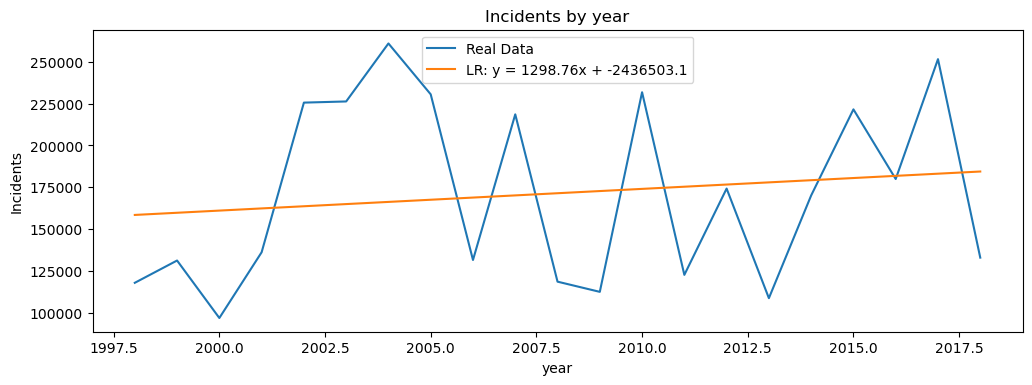

In [6]:
a, b = np.polyfit(np.arange(21) + 1998, incidents_by_year, 1)

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 

fig, ax = plt.subplots()

plt.plot(np.arange(21) + 1998, incidents_by_year, label="Real Data")
plt.plot(np.arange(21) + 1998, a*(np.arange(21) + 1998) + b, label=f"LR: y = {np.round(a,2)}x + {np.round(b,2)}")

ax.legend()
ax.set_title("Incidents by year")
ax.set_ylabel("Incidents")
ax.set_xlabel("year")
print()

Observa-se que existe uma tendência crescente no número de queimadas no Brasil, aumentando os incidentes em 1300 por ano aproximandamente. Um teste de hipóteses não paramétrico poderia ser utilizado para garantir a confiabilidade do valor do coeficiente 'a'. Para simplificar admitiremos que existe sim uma tendência crescente nos incidentes, mostrando assim que o ano é uma variável importante para o modelo. Quanto a variação observada, uma investigação a respeito dos anos mais secos e efeitos metereológicos pode ser realizada.

### Testes de hipóteses não paramétricos

#### P nesse caso representa a probabilidade de se obter um resultado igual ou mais extremo que o encontrado na prática.

In [7]:
arr = incidents_by_year.copy()

a, b = np.polyfit(np.arange(21) + 1998, incidents_by_year, 1)

strangers = 0
n_simulation = 1000
for i in range(n_simulation):
    np.random.shuffle(arr)
    p_a, p_b = np.polyfit(np.arange(21) + 1998, arr, 1)
    if p_a >= a:
        strangers += 1

print(f"P-value: {strangers/n_simulation}")


P-value: 0.267


Quando considerado o valor alpha=0.05 não podemos admitir que o valor obtido na regressão seja significativo estatisticamente. Porém isso pode ser um problema gerado pela baixa quantidade de samples no conjunto de dados. Para se obter mais dados poderíamos criar um bot que os baixasse no site do INPE.

## Incidents by Month

In [8]:
incidents_by_month = agregated_data.groupby("month").sum('incidents')['incidents'].values

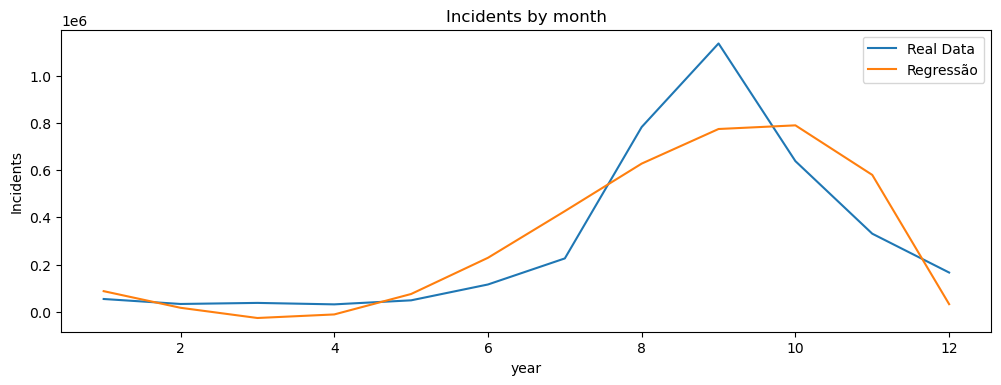

In [9]:
a, b, c, d, e = np.polyfit(np.arange(12) + 1, incidents_by_month, 4)

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 

fig, ax = plt.subplots()

ax.plot(np.arange(12) + 1, incidents_by_month, label="Real Data")
ax.plot(np.arange(12) + 1, a*((np.arange(12) + 1)**4) + 
         b*((np.arange(12) + 1)**3) + c*(np.arange(12) + 1)**2 + d*(np.arange(12) + 1) + e, 
         label="Regressão")

ax.legend()
ax.set_title("Incidents by month")
ax.set_ylabel("Incidents")
ax.set_xlabel("year")
print()

Podemos observamos que precisamos de um polinômio de grau 4 para ter uma representação relativamente ok do efeito que os meses possuem sobre a quantidade de incidentes. De fato, sabemos fenomenologicamente que os meses com maior quantidade de incidentes tendem a ser mais secos nas principais regiões onde acontecem as queimadas, explicando a curva observada. Surge aqui a ideia de representar cada mês do ano com um novo modelo através dos anos.

## Incidents by Month and Year

In [10]:
incidents_by_month_and_year = np.zeros((12, 21))

for month in range(1, 13, 1):
    for year in range(1998, 2019, 1):
            try:
                incidents_by_month_and_year[month - 1][year - 1998] = agregated_data.loc[agregated_data['state'] == 'amazonas'].loc[agregated_data['month'] == month].loc[agregated_data['year'] == year]['incidents'].sum()
            except:
                incidents_by_month_and_year[month - 1][year - 1998] = 0 

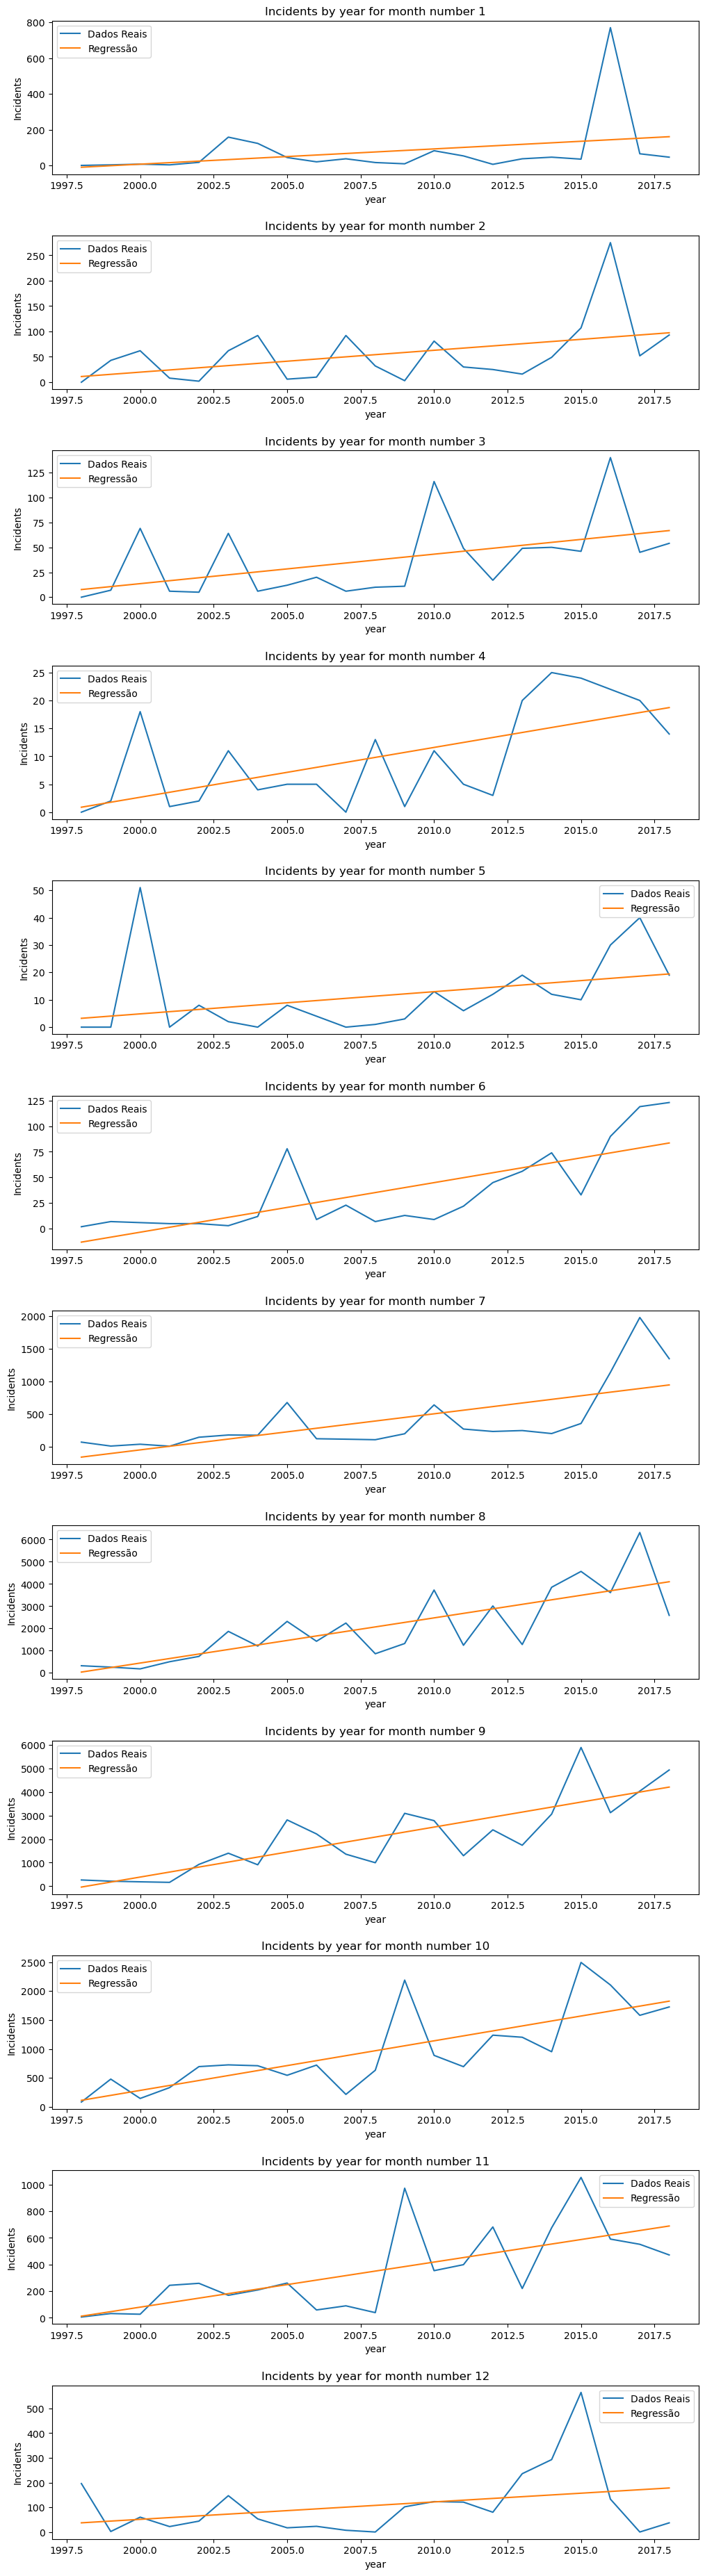

In [11]:
plt.rcParams['figure.figsize'] = [12, 4*12]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['figure.subplot.hspace'] = 0.4 

fig, axs = plt.subplots(12)

for i in range(12):
    a, b = np.polyfit(np.arange(21) + 1998, incidents_by_month_and_year[i], 1)
    
    axs[i].plot(np.arange(21) + 1998, incidents_by_month_and_year[i], label=f"Dados Reais")
    axs[i].plot(np.arange(21) + 1998, a*(np.arange(21) + 1998) + b, label=f"Regressão")
    
    axs[i].legend()
    axs[i].set_title(f"Incidents by year for month number {i+1}")
    axs[i].set_ylabel("Incidents")
    axs[i].set_xlabel("year")

Percebe-se que a ideia de fazer um modelo linear para cada mês do ano é bastante promissora!

## Incidents by latitude and longitude

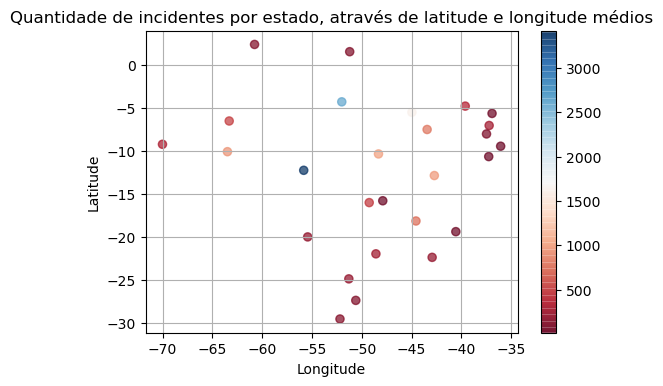

In [12]:
aux = agregated_data.groupby('state').mean()

fig = plt.figure(figsize = (6,4))
ax1 = fig.add_subplot(1,1,1)

sc = ax1.scatter(x = aux['longitude_mean'],
                y = aux['latitude_mean'], 
                c = aux['incidents'],
                vmin = aux['incidents'].min(), vmax = aux['incidents'].max(),
                alpha = 0.7, s = 35, cmap = 'RdBu')

plt.colorbar(sc)
ax1.set_xlabel("Longitude", size = 10)
ax1.set_ylabel("Latitude", size = 10)
ax1.set_title("Quantidade de incidentes por estado, através de latitude e longitude médios")
ax1.grid()
print()

In [13]:
aux = inpe_data.groupby('city').mean()[['latitude', 'longitude']]
aux2 = inpe_data.groupby('city').count()['latitude']
aux['incidents'] = aux2.values

In [14]:
aux.sort_values(by="incidents", ascending=True, inplace=True)
aux = aux.loc[aux['incidents'] > 150]

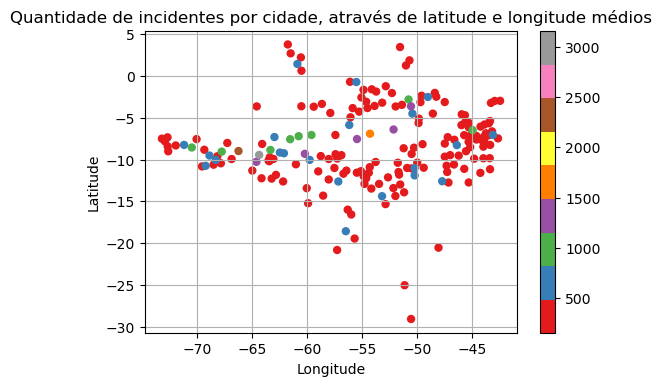

In [15]:
fig = plt.figure(figsize = (6,4))
ax1 = fig.add_subplot(1,1,1)

sc = ax1.scatter(x = aux['longitude'],
                y = aux['latitude'], 
                c = aux['incidents'],
                vmin = aux['incidents'].min(), vmax = aux['incidents'].max(),
                alpha = 1, s = 25, cmap = 'Set1')

plt.colorbar(sc)
ax1.set_xlabel("Longitude", size = 10)
ax1.set_ylabel("Latitude", size = 10)
ax1.set_title("Quantidade de incidentes por cidade, através de latitude e longitude médios")
ax1.grid()

Podemos observar que existe sim relação da quantidade de incidentes com a localização da cidade. Fenomenologicamente falando isso é bastante claro. As variáveis de latitude e longitude podem ser usadas futuramente em um modelo único que use como entrada o 'estado', que pode ter seu encoding realizado através dessas duas variáveis de proxy.

## Incidents and La Nina and El Nino effects

In [21]:
print(agregated_data.groupby('la nina').mean()['incidents'], agregated_data.groupby('la nina').count()['incidents'])

la nina
0    641.088057
1    664.645455
2    464.238636
3    662.263258
Name: incidents, dtype: float64 la nina
0    2964
1    1320
2     264
3    1056
Name: incidents, dtype: int64


In [22]:
print(agregated_data.groupby('el nino').mean()['incidents'], agregated_data.groupby('el nino').count()['incidents'])

el nino
0    634.316288
1    623.133513
2    640.164773
4    839.276515
Name: incidents, dtype: float64 el nino
0    3696
1    1116
2     528
4     264
Name: incidents, dtype: int64


It seems that the effects of the events are small or doesnt exist. To analyse if this events really hava an effect on the quantity of incidents we can perform some hypothesis tests.